# Import required libraries

In [19]:
import glob

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Read image
Đọc ảnh bằng hàm cv.imread, với params bằng 0 (đọc với định dạng grayscale, đỡ phải convert)

In [20]:
path = "././input/set1/"

current_image = cv.imread(path + "4.png", 0)

# plt.imshow(current_image, cmap='gray')

images = []

for img_path in glob.glob(path + '*.png'):
    images.append(cv.imread(img_path, 0))

original_images = images

### Show all images

In [21]:
def show_all_images(showed_images=images, titles=[]):
    plt.figure(figsize=(20, 10))
    columns = 5

    for i, image in enumerate(showed_images):
        if titles:
            plt.title(titles[i])
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image, cmap='gray')

C:\Users\calll\AppData\Local\Temp/ipykernel_6472/1073169845.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


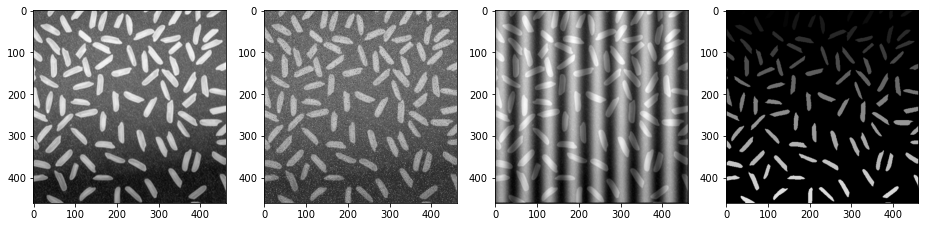

In [22]:
show_all_images()

# Gaussian blur
Remove salt&pepper noise.

C:\Users\calll\AppData\Local\Temp/ipykernel_6472/1073169845.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


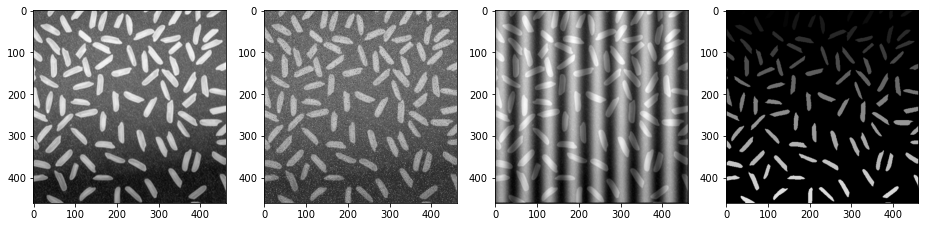

In [23]:
def apply_gaussian_blur(image):
    return cv.GaussianBlur(image, (7, 7), 0)


images = list(map(apply_gaussian_blur, images))

show_all_images()

# Apply adaptive thresholding using the mean threshold method
Sử dụng ngưỡng thích ứng cục bộ (adaptive local threshold). Thuật toán này sẽ tìm một ngưỡng phù hợp cho từng pixel. Phương pháp này sẽ không lấy 1 ngưỡng cố định cho toàn bộ ảnh, bởi lẽ do nguồn sáng của các vị trí trên ảnh là khác nhau. Nếu lấy 1 giá trị cố định thì sẽ có trường hợp phần nền bị đánh màu trắng, hạt gạo đánh màu đen. Do đó mới sử dụng adaptive threshold, nó sẽ tnihs giá trị trung bình của n điểm ảnh xung quanh 1 pixel đang xét, sau đó trừ cho hằng số C (n thường là số lẻ và C sẽ là số nguyên bất kỳ từ -255 đến 255). Các tham số n, C chúng em thử nhiều lần thôi chứ cũng ko có kinh nghiệm chọn cụ thể cho từng bài.


- ADAPTIVE_THRESH_MEAN_C là cách tính giá trị ngưỡng theo trung bình như bên trên đã nói


- Tham số thứ 5 là số điểm ảnh xung quanh để lấy trung bình (là số lẻ 3,5,7,..)


- Tham số thứ 6 là hằng số C


Đọc thêm về hàm adaptiveThreshold ở đây: https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html

C:\Users\calll\AppData\Local\Temp/ipykernel_6472/1073169845.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


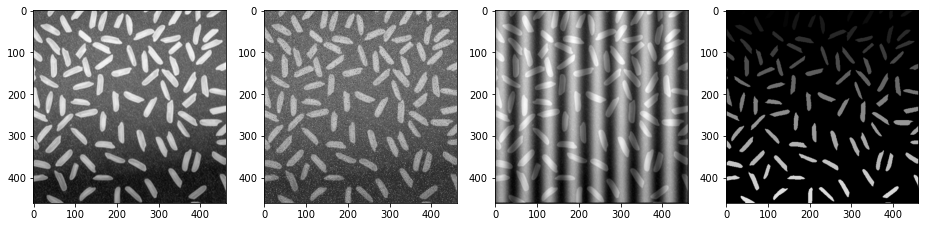

In [24]:
# output_adapthresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 301, 0)  #set 1
# output_adapthresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 201, 10) #set 2
# plt.imshow(output_adapthresh, cmap='gray')
def apply_thresh_hold(image):
    return cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 301, 0)


images = list(map(apply_thresh_hold, images))

show_all_images()

# Fourier transform
output đang không phải là uint8, mà hàm threshold của opencv thì require input dạng uint8. Tuy nhiên không thể convert trực tiếp từ output của fourier về np.uint8 được luôn vì mất tính chất của fourier trên ảnh.

In [25]:
# dft = cv.dft(np.float32(blur), flags=cv.DFT_COMPLEX_OUTPUT)
# dft_shift = np.fft.fftshift(dft)
#
# rows, cols = current_image.shape
# crow, ccol = int(rows / 2), int(cols / 2)
#
# mask = np.zeros((rows, cols, 2), np.uint8)
# mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 1
#
# fshift = dft_shift * mask
# f_ishift = np.fft.ifftshift(fshift)
# img_back = cv.idft(f_ishift)
# img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
#
# plt.imshow(img_back, cmap='gray')

# Morphological erosion
Xói mòn nhằm loại bỏ những pixel nhiễu xung quanh đối tượng làm cho phần viền đối tượng trở nên mịn hơn, nhỏ hơn và tách được các đối tượng chạm vào nhau

kernel sẽ trượt qua tất cả pixel của ảnh. Một pixel được set là 1 nếu tất cả các pixel trong kernel là 1 và ngược lại sẽ bị chuyển thành 0.

C:\Users\calll\AppData\Local\Temp/ipykernel_6472/1073169845.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


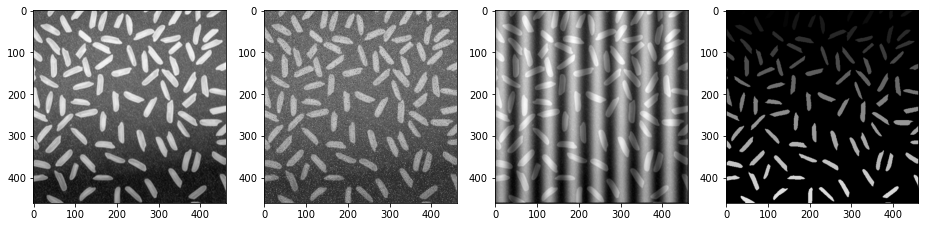

In [26]:
# kernel = np.ones((13,13),np.uint8) #set 2
def apply_morphological_erosion(image):
    kernel = np.ones((5, 5), np.uint8)  #set 1
    return cv.erode(image, kernel)

images = list(map(apply_morphological_erosion, images))

show_all_images()

# Add counting number to each contour function

C:\Users\calll\AppData\Local\Temp/ipykernel_6472/1073169845.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1)


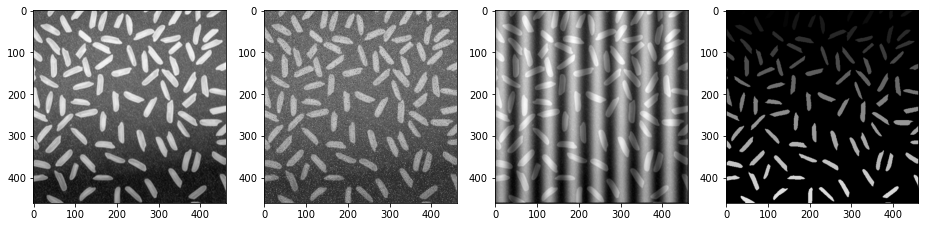

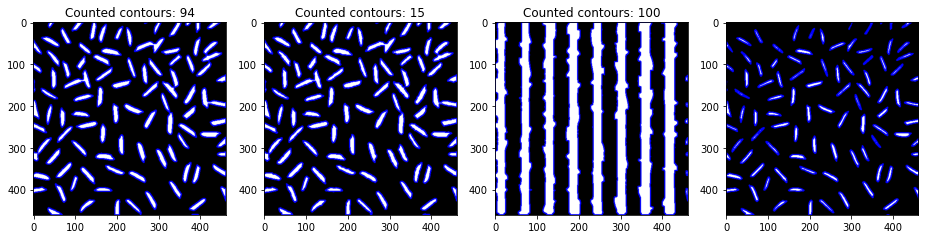

In [27]:
titles = []
def apply_find_contours(image):

    contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  #set 1
    titles.append('Counted contours: ' + str(len(contours)))

    # Draw contour
    output_contour = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    return cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)

images = list(map(apply_find_contours, images))

show_all_images(showed_images=original_images)
show_all_images(showed_images=images, titles=titles)